In [12]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

### Предсказание типов цветков Ириса

Подготовим данные для обучения модели. В качестве демонстрационного датасета возьмем 2 класса из известного датасета описания цветов ириса - по характеристикам цветка требуется определить его тип. Это простой линейной разделимый датасет - как раз для нашей задачи. 

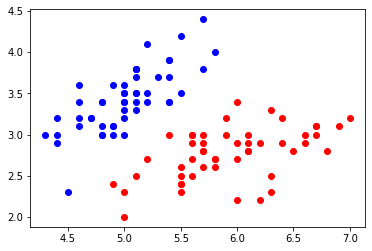

In [13]:
#загружаем датасет из библиотеки sklearn - стандартные датасеты для обучения
iris = datasets.load_iris()
iris_X = iris.data[:, :2]
iris_y = iris.target

#для обучения возьмем всего 2 признака из обучающей выборки для визуализации 
iris_X = iris_X[iris_y < 2]
#и возьмем только 2 класса из выборки - мы обучаем логистическую регрессию
iris_y = iris_y[iris_y < 2]

# для визуализации сделаем 2 класса - +1 и -1 
iris_y[iris_y == 0] = -1

# красным отобразим класс +1
plt.scatter(iris_X[iris_y > 0, 0], iris_X[iris_y > 0, 1], color='r')
# синим отобразим класс -1
plt.scatter(iris_X[iris_y < 0, 0], iris_X[iris_y < 0, 1], color='b')

### Минимизация с помощью кросс-энтропии

Аналогично реализуем метод обучения с помощью бинарной кросс-энтропии.  

In [14]:
# добавим bias член к нашему датасету
X = np.concatenate((np.ones((iris_X.shape[0], 1)), iris_X), axis=1)

y = iris_y.reshape(-1,1)
#класс -1 у нас превращается в 0 для использования в функции ошибки
y[y == -1] = 0

print(X.shape, y.shape)

(100, 3) (100, 1)


Train acc score:  99.0
Weights:  [-0.69338939  3.04271251 -5.09949597]


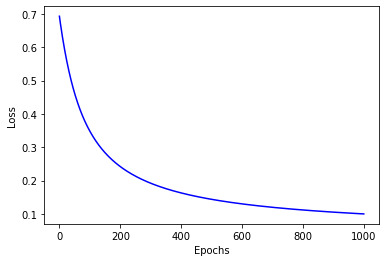

In [4]:
class LogisticRegressionCE:
    """
        Инициализирует объект класса LogisticRegressionCE.

        Параметры:
        - num_epochs (int): Количество эпох обучения.
        - step_size (float): Размер шага градиентного спуска.
    """
    def __init__(self, num_epochs, step_size):
        self.num_epochs = num_epochs
        self.step_size = step_size
        
    def objective_value(self, x, w, y):
        """Вычисляет значение бинарной кросс-энтропии.

        Параметры:
        - x (numpy.ndarray): Входные данные.
        - w (numpy.ndarray): Весовые коэффициенты модели.
        - y (numpy.ndarray): Истинные метки классов.

        Возвращает:
        - loss (numpy.ndarray): Значение функции потерь.
        """
        loss = -(1/len(X))*(np.dot(y.T, np.log(self.sigmoid(x, w))) + np.dot((1-y).T, np.log(1 - self.sigmoid(x, w))))
        return loss.flatten()
    
    def objective_grad(self, x, w, y):
        """Вычисляет градиент бинарной кросс-энтропии.

        Параметры:
        - x (numpy.ndarray): Входные данные.
        - w (numpy.ndarray): Весовые коэффициенты модели.
        - y (numpy.ndarray): Истинные метки классов.

        Возвращает:
        - grad (numpy.ndarray): Градиент функции потерь по весам.
        """
        return np.dot(X.T, (self.sigmoid(x, w) - y))

    def sigmoid(self, x, w):
        """Вычисляет значение функции сигмоида.

        Параметры:
        - x (numpy.ndarray): Входные данные.
        - w (numpy.ndarray): Весовые коэффициенты модели.

        Возвращает:
        - result (numpy.ndarray): Значение сигмоидной функции.
        """
        return 1/(1+np.exp(-np.dot(x, w))) 
    
    def fit(self, x, y):
        """Обучает модель с использованием метода градиентного спуска.

        Параметры:
        - x (numpy.ndarray): Входные данные.
        - y (numpy.ndarray): Истинные метки классов.

        Возвращает:
        - results (dict): Словарь с результатами обучения, включая список значений функции потерь и обученные веса модели.
        """
        loss_list = []
        current_weight = np.zeros(x.shape[1]).reshape(-1,1)
        for epoch in range(self.num_epochs):
            loss = self.objective_value(x, current_weight, y)
            grad = self.objective_grad(x, current_weight, y)
            current_weight = current_weight - self.step_size*grad
            loss_list.append(loss)
        return {'loss_list': loss_list, 'weights': current_weight}
    
    def predict(self, x, w, treshhold):
        """Прогнозирует классы на основе вероятностей с учетом порога.

        Параметры:
        - x (numpy.ndarray): Входные данные.
        - w (numpy.ndarray): Весовые коэффициенты модели.
        - threshold (float): Порог для отнесения объекта к классу 1.

        Возвращает:
        - prediction (dict): Словарь с вероятностями и предсказанными метками классов.
        """
        proba = self.sigmoid(x, w)
        #если вероятность выше порога - присваиваем класс 1
        labels = (proba >= treshhold).astype(int).flatten().reshape(-1,1)
        return {"proba": proba, "labels": labels}
    
    def score(self, y_pred, y_true):
        """рассчет точности нашей модели - процент верно предсказанных объектов"""
        accuracy = np.mean(y_pred == y_true)
        return accuracy * 100
    
    
#инициализируем модели
log_reg = LogisticRegressionCE(num_epochs=1000, step_size=0.001)
#обучаем модель
result = log_reg.fit(X, y)
#делаем предсказание
prediction = log_reg.predict(X, result['weights'], 0.5)
#рассчитываем метрику
accuracy_score = log_reg.score(prediction['labels'], y)
print('Train acc score: ', accuracy_score)
print('Weights: ', result['weights'].flatten())
plt.plot(range(len(result['loss_list'])), result['loss_list'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

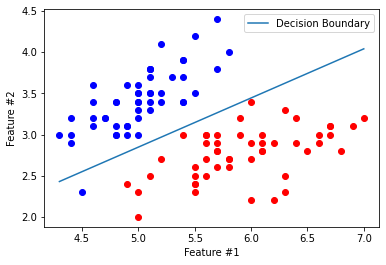

In [5]:
def get_line(x,y):
    """рассчет параметров раздяляющей прямой"""
    m = (y[1] - y[0])/(x[1] - x[0])
    b = y[0]-m*x[0]
    return m,b

def plot_decision_boundary(X, y, w):
    """
    Отображает графически разделяющую прямую на графике.
    w[2] * y = -(w[1] * x + w[0])

    Параметры:
    - X (numpy.ndarray): Матрица признаков объектов.
    - y (numpy.ndarray): Массив меток классов.
    - w (numpy.ndarray): Веса модели, определяющие разделяющую прямую.

    Визуализирует разделяющую прямую, созданную на основе весов w,
    а также объекты из класса '1' (положительные) и '0' (отрицательные).
    """
    
    x_values = np.array([np.min(X[:, 0]), np.max(X[:, 1])]).reshape(-1,1)
    y_values = (-(w[0] + np.dot(w[1].reshape(1,1), x_values.T)) / w[2])
    m, b = get_line(x_values.flatten(), y_values.flatten())

    x_line = np.linspace(np.min(X[:, 0]),np.max(X[:, 0]),10)
    y_line = m*x_line + b

    y[y == np.min(y)] = -1
    
    plt.scatter(X[y > 0, 0], X[y > 0, 1], color='r')
    plt.scatter(X[y < 0, 0], X[y < 0, 1], color='b')

    plt.plot(x_line, y_line , label='Decision Boundary')
    plt.xlabel('Feature #1')
    plt.ylabel('Feature #2')


    plt.legend()
    plt.show()
    
X_plot = X[:,1:]
y_plot = y.flatten()
plot_decision_boundary(X_plot, y_plot, result['weights'])

### Максимизация расстояния до разделяющей прямой

In [6]:
X = np.concatenate((np.ones((iris_X.shape[0], 1)), iris_X), axis=1)

y = iris_y.reshape(-1,1)
y[y == np.min(y)] = -1
print(X.shape, y.shape)

(100, 3) (100, 1)


Train acc score:  99.0
Weights:  [-0.69338939  3.04271251 -5.09949597]


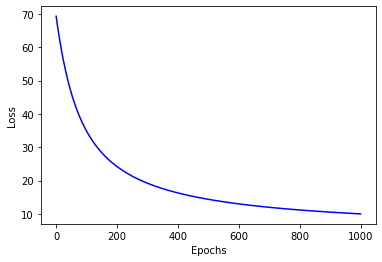

In [7]:
class LogisticRegressionMarginMaximization:
    def __init__(self, num_epochs, step_size):
        """
        Инициализирует объект класса LogisticRegressionMarginMaximization.

        Параметры:
        - num_epochs (int): Количество эпох обучения.
        - step_size (float): Размер шага градиентного спуска.
        """
        self.num_epochs = num_epochs
        self.step_size = step_size
        
    def objective_value(self, x, w, y):
        """
        Вычисляет значение логистической функции ошибки.

        Параметры:
        - x (numpy.ndarray): Матрица признаков объектов.
        - w (numpy.ndarray): Веса модели.
        - y (numpy.ndarray): Истинные метки классов.

        Возвращает:
        - pobj (float): Значение функции ошибки.
        """        
        pobj = np.sum(np.log(1. + np.exp(- y * np.dot(X, w))))
        return pobj
    
    def objective_grad(self, x, w, y):
        """
        Вычисляет градиент логистической функции ошибки.

        Параметры:
        - x (numpy.ndarray): Матрица признаков объектов.
        - w (numpy.ndarray): Веса модели.
        - y (numpy.ndarray): Истинные метки классов.

        Возвращает:
        - grad (numpy.ndarray): Градиент функции ошибки по весам.
        """
        ywTx = y * np.dot(X, w)
        temp = 1. / (1. + np.exp(ywTx))
        grad = -np.dot(X.T, (y * temp))
        return grad
    
    def fit(self, x, y):
        """
        Обучает модель с использованием метода градиентного спуска.

        Параметры:
        - x (numpy.ndarray): Матрица признаков объектов.
        - y (numpy.ndarray): Истинные метки классов.

        Возвращает:
        - results (dict): Словарь с результатами обучения, включая список значений функции ошибки и обученные веса модели.
        """
        loss_list = []
        current_weight = np.zeros(x.shape[1]).reshape(-1,1)
        for epoch in range(self.num_epochs):
            loss = self.objective_value(x, current_weight, y)
            grad = self.objective_grad(x, current_weight, y)
            current_weight = current_weight - self.step_size*grad
            loss_list.append(loss)
        return {'loss_list': loss_list, 'weights': current_weight}
    
    def predict(self, x, w):
        """
        Прогнозирует метки классов на основе весов модели.

        Параметры:
        - x (numpy.ndarray): Матрица признаков объектов.
        - w (numpy.ndarray): Веса модели.

        Возвращает:
        - prediction (dict): Словарь с предсказанными метками классов и значениями "margin" (отступ).
        """
        wTx = np.dot(x, w)
        margin = (wTx > 0).astype(int).flatten().reshape(-1,1)
        labels = np.array(list(map(lambda x: 1 if x > 0 else -1, margin))).reshape(-1,1)
        return {"margin": margin, "labels": labels}
    
    def score(self, y_pred, y_true):
        """
        Вычисляет точность модели в процентах.

        Параметры:
        - y_pred (numpy.ndarray): Предсказанные метки классов.
        - y_true (numpy.ndarray): Истинные метки классов.

        Возвращает:
        - accuracy (float): Точность модели в процентах.
        """
        accuracy = np.mean(y_pred == y_true)
        return accuracy * 100
    
    
log_reg = LogisticRegressionMarginMaximization(num_epochs=1000, step_size=0.001)
result = log_reg.fit(X, y)
prediction = log_reg.predict(X, result['weights'])
accuracy_score = log_reg.score(prediction['labels'], y)
print('Train acc score: ', accuracy_score)
print('Weights: ', result['weights'].flatten())
plt.plot(range(len(result['loss_list'])), result['loss_list'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

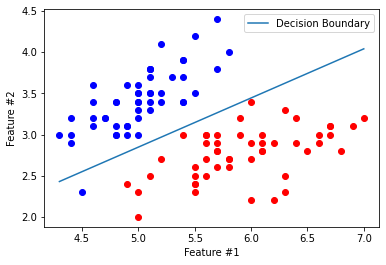

In [8]:
X_plot = X[:,1:]
y_plot = y.flatten()
plot_decision_boundary(X_plot, y_plot, result['weights'])

In [10]:
### CODE HERE